In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from contextlib import redirect_stdout

# A Simple 24-Hour Example
This network will contain **one bus**, **four generators**, and **one load**.

### The First Step
We always begin by creating a *network* object, as this is what will hold all of the components in our example.

In [2]:
#Create a new PyPSA network object
network = pypsa.Network()

### The Bus
Adding a bus component to the network is the next step, as **a bus is required in order to add the generators and the load to the network.** For this network, the bus will have an attribute *v_nom* set to 20.

In [3]:
#Add a Bus called 'The Bus' to the network
network.add(class_name='Bus', name='The Bus', v_nom=20)

#Printing the network, it has one bus and one snapshot. Printing the buses shows the newly added bus that we added in the code snippet above.
print(network)
print(network.buses)

PyPSA Network
Components:
 - Bus: 1
Snapshots: 1
attribute  v_nom type    x    y carrier unit  v_mag_pu_set  v_mag_pu_min  \
Bus                                                                        
The Bus     20.0       0.0  0.0      AC                1.0           0.0   

attribute  v_mag_pu_max control sub_network  
Bus                                          
The Bus             inf      PQ              


### The Load
For this particular example, the load will follow a **sine curve pattern**. It will use hourly timestamps for 24 hours.

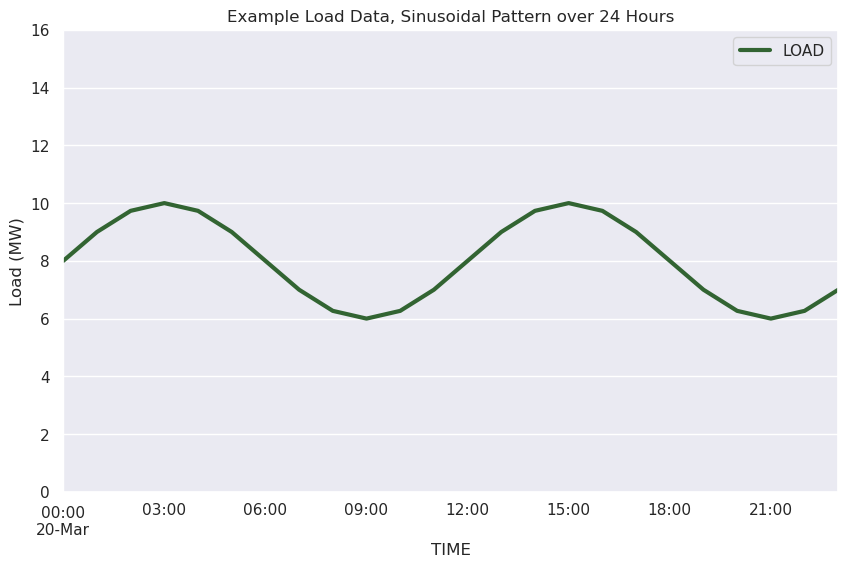

In [4]:
#A slightly weird way to do this, but I want some points to lie on exact integers
load_data = 2*np.sin(np.linspace(start=0, stop=4*np.pi, num=25)) + 8
load_data = load_data.tolist()[0:24]

#Creating an hourly timestamped data frame for the load
load_series = pd.DataFrame(data={
    'TIME': pd.date_range(start='2019-03-20 00:00:00', end='2019-03-20 23:00:00', freq='h'),
    'LOAD': load_data
})
load_series = load_series.set_index('TIME')

#Seeing what the load data looks like on a plot
sns.set_theme()
load_series.plot(figsize=(10, 6), linewidth=3, color='#326432')
plt.title('Example Load Data, Sinusoidal Pattern over 24 Hours')
plt.ylabel('Load (MW)')
plt.ylim(0, 16)
plt.show()

In [5]:
#Adding the load to the bus in order to connect it to the network
#Start by setting the snapshots to be the timestamps in load_series
network.snapshots = load_series.index

#Now add the Load component to the network. We have to specify the bus it is connected to
network.add(class_name='Load', name='Sine Load', bus='The Bus', p_set=load_series['LOAD'])

#See the load time series allocated to this network
network.loads_t

{'p_set': Load                 Sine Load
 snapshot                      
 2019-03-20 00:00:00   8.000000
 2019-03-20 01:00:00   9.000000
 2019-03-20 02:00:00   9.732051
 2019-03-20 03:00:00  10.000000
 2019-03-20 04:00:00   9.732051
 2019-03-20 05:00:00   9.000000
 2019-03-20 06:00:00   8.000000
 2019-03-20 07:00:00   7.000000
 2019-03-20 08:00:00   6.267949
 2019-03-20 09:00:00   6.000000
 2019-03-20 10:00:00   6.267949
 2019-03-20 11:00:00   7.000000
 2019-03-20 12:00:00   8.000000
 2019-03-20 13:00:00   9.000000
 2019-03-20 14:00:00   9.732051
 2019-03-20 15:00:00  10.000000
 2019-03-20 16:00:00   9.732051
 2019-03-20 17:00:00   9.000000
 2019-03-20 18:00:00   8.000000
 2019-03-20 19:00:00   7.000000
 2019-03-20 20:00:00   6.267949
 2019-03-20 21:00:00   6.000000
 2019-03-20 22:00:00   6.267949
 2019-03-20 23:00:00   7.000000,
 'q_set': Empty DataFrame
 Columns: []
 Index: [2019-03-20 00:00:00, 2019-03-20 01:00:00, 2019-03-20 02:00:00, 2019-03-20 03:00:00, 2019-03-20 04:00:00, 2019-

### The Generators
There will be **four generators** in this network. There will be **two baseloads** and **two peakers**. For each of these categories, one will have a **fixed nominal power**, while the other will be **extendable**.

The baseload generators have a low marginal cost of **$6/MW**, but in order to extend the capacity, it will cost **$60/MW**.

The peaker generators have a higher marginal cost of **$10/MW**, but extending the capacity only costs **$5/MW**.

In [6]:
#The baseloads
network.add(class_name='Generator', name='Baseload Fixed', bus='The Bus', p_nom=4, p_nom_extendable=False, marginal_cost=6)
network.add(class_name='Generator', name='Baseload Extendable', bus='The Bus', p_nom=0, p_nom_extendable=True, p_nom_max=15, marginal_cost=6, capital_cost=60)

In [7]:
#The peakers
network.add(class_name='Generator', name='Peaker Fixed', bus='The Bus', p_nom=6, p_nom_extendable=False, marginal_cost=10)
network.add(class_name='Generator', name='Peaker Extendable', bus='The Bus', p_nom=0, p_nom_extendable=True, p_nom_max=15, marginal_cost=10, capital_cost=5)
network.generators

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
Baseload Fixed,The Bus,PQ,,4.0,False,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Baseload Extendable,The Bus,PQ,,0.0,True,0.0,15.0,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Peaker Fixed,The Bus,PQ,,6.0,False,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Peaker Extendable,The Bus,PQ,,0.0,True,0.0,15.0,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [8]:
#Taking a look at our network now that all of the components are set
network

PyPSA Network
Components:
 - Bus: 1
 - Generator: 4
 - Load: 1
Snapshots: 24

# Creating the *linopy* Model
Now we can begin constructing the linear programming model. This model is comprised of a collection of **variables** and **constraints**.

In [9]:
#Creating a linopy model from our network
model = network.optimize.create_model()
model

Linopy LP model

Variables:
----------
 * Generator-p_nom (Generator-ext)
 * Generator-p (snapshot, Generator)

Constraints:
------------
 * Generator-ext-p_nom-lower (Generator-ext)
 * Generator-ext-p_nom-upper (Generator-ext)
 * Generator-fix-p-lower (snapshot, Generator-fix)
 * Generator-fix-p-upper (snapshot, Generator-fix)
 * Generator-ext-p-lower (snapshot, Generator-ext)
 * Generator-ext-p-upper (snapshot, Generator-ext)
 * Bus-nodal_balance (Bus, snapshot)

Status:
-------
initialized

### Solving the Network as It Is
Below we take a look at what the optimal solution for this network is without any constraints acting on it.

In [10]:
#Run the solver, specifically the 'cbc' one since it's pretty fast
network.optimize.solve_model(solver_name='cbc')

INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 98 primals, 220 duals
Objective: 1.45e+03
Solver model: not available
Solver message: Optimal - objective value 1447.71281292


INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Apr 19 2023 

command line - cbc -printingOptions all -import /tmp/linopy-problem-x2eqk67z.lp -solve -solu /tmp/linopy-solve-ire7t7zc.sol (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 72 (-148) rows, 98 (0) columns and 192 (-148) elements
Perturbing problem by 0.001% of 60 - largest nonzero change 0.000644292 ( 0.0022201021%) - largest zero change 0
0  Obj 0 Primal inf 191.99998 (24)
40  Obj 1447.7207
Optimal - objective value 1447.7128
After Postsolve, objective 1447.7128, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 1447.712813 - 40 iterations time 0.002, Presolve 0.00
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00



('ok', 'optimal')

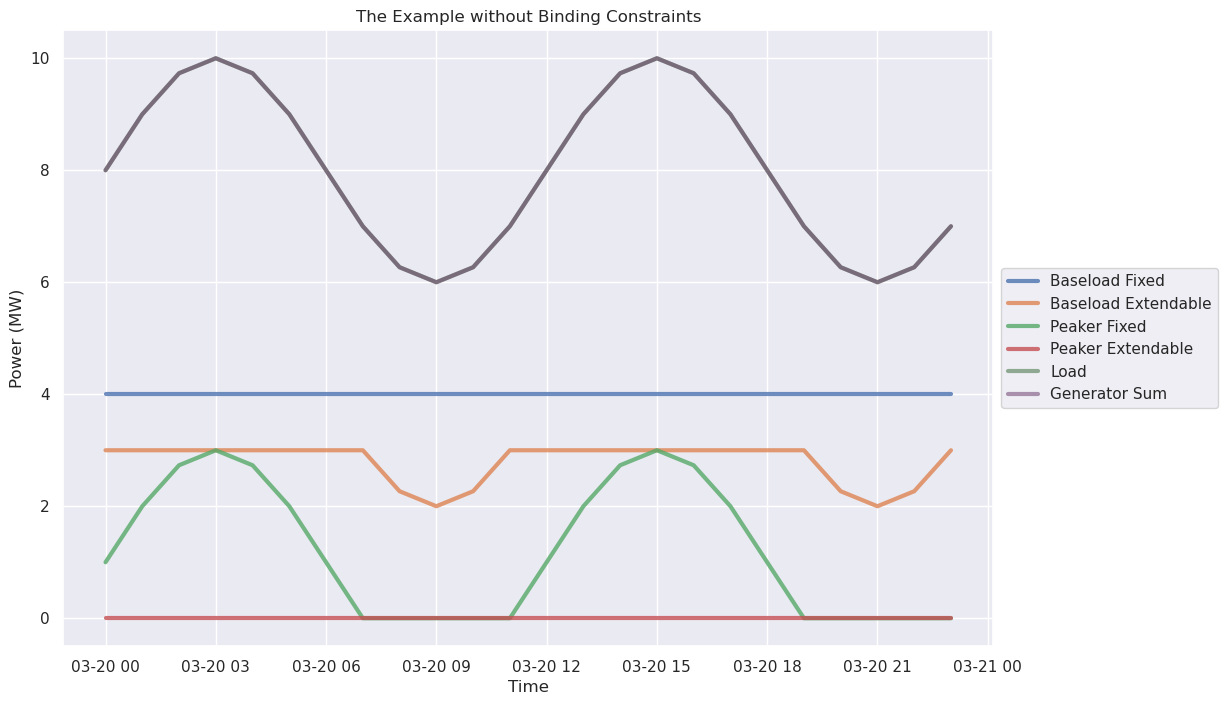

In [11]:
#This is what PyPSA has produced for the power time series for each generator in the network
gen = network.generators_t.p['Baseload Fixed'] + network.generators_t.p['Baseload Extendable'] + network.generators_t.p['Peaker Fixed'] + network.generators_t.p['Peaker Extendable']
plt.figure(figsize=(12, 8))
plt.plot(network.generators_t.p, linewidth=3, alpha=0.8)
plt.plot(load_series, linewidth=3, color='#326432', alpha=0.5)
plt.plot(gen, linewidth=3, color='#643264', alpha=0.5)
plt.legend(['Baseload Fixed', 'Baseload Extendable', 'Peaker Fixed', 'Peaker Extendable', 'Load', 'Generator Sum'], loc='right', bbox_to_anchor=(1.25, 0.5))
plt.title('The Example without Binding Constraints')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.show()

In [12]:
#Taking a look at how much the solution invested into the extendable generators. Peaker Extended was completely ignored in this solution
model.variables['Generator-p_nom'].solution

<xarray.DataArray 'solution' (Generator-ext: 2)>
array([ 3., -0.])
Coordinates:
  * Generator-ext  (Generator-ext) object 'Baseload Extendable' 'Peaker Exten...

In [13]:
#How much money did each generator cost in the optimal solution?
bl_cost = round(network.generators_t.p['Baseload Fixed'].sum() * network.generators.loc['Baseload Fixed']['marginal_cost'], 2)
bl_cost_2 = round(network.generators_t.p['Baseload Extendable'].sum() * network.generators.loc['Baseload Extendable']['marginal_cost'], 2) + round(model.variables['Generator-p_nom'].solution.values[0] * network.generators.loc['Baseload Extendable']['capital_cost'], 2)
p_cost = round(network.generators_t.p['Peaker Fixed'].sum() * network.generators.loc['Peaker Fixed']['marginal_cost'], 2)
p_cost_2 = round(network.generators_t.p['Peaker Extendable'].sum() * network.generators.loc['Peaker Extendable']['marginal_cost'], 2) + round(model.variables['Generator-p_nom'].solution.values[1] * network.generators.loc['Peaker Extendable']['capital_cost'], 2)

print('Baseload Fixed: $' + str(bl_cost))
print('Baseload Extendable: $' + str(bl_cost_2))
print('Peaker Fixed: $' + str(p_cost))
print('Peaker Extendable: $' + str(p_cost_2))

#The total cost is the same as the solution found in the solver, which is labelled as the 'optimal objective'
print('The total cost was $' + str(round(bl_cost + bl_cost_2 + p_cost + p_cost_2, 2)))

Baseload Fixed: $576.0
Baseload Extendable: $582.4300000000001
Peaker Fixed: $289.28
Peaker Extendable: $0.0
The total cost was $1447.71


In the above example, **it just ran the generator with the lower marginal cost for basically the entire load.** Only at the very peak load did it bother to turn on the generator with the higher marginal cost. Below, we will try to make amends by adding constraints that will change how the generators are utilized to meet the load demand.

### Adding a Custom Constraint
Suppose that generators need to be able to meet a percentage of the load greater than the load at the next time stamp.

The equation looks like:

$\sum_{i \in Generators}(G_i - g_{t, i}) \geq avail_{t+1}^{reserve} \cdot L_t \forall t \in T$

To make this easier to work with for creating constraints, I will distribute the summation on the left hand side.

$\sum_{i \in Generators}(G_i - g_{t, i}) \Rightarrow \sum_{i \in Generators}G_i - \sum_{i \in Generators}g_{t, i}$

This new equation will look like:

$\sum_{i \in Generators}G_i - \sum_{i \in Generators}g_{t, i} \geq avail_{t+1}^{reserve} \cdot L_t \forall t \in T$


Where $reserve$ is the percentage of power needed to be set aside for "reserve" power. For this example, the "reserve" will start at 0, then linearly increase towards 0.5 halfway through the time, then stay at 0.5 for the rest of the time.

In [14]:
model.variables

linopy.model.Variables
----------------------
 * Generator-p_nom (Generator-ext)
 * Generator-p (snapshot, Generator)

In [15]:
model.variables['Generator-p']

Variable (snapshot: 24, Generator: 4)
-------------------------------------
[2019-03-20T00:00:00.000000000, Baseload Fixed]: Generator-p[2019-03-20 00:00:00, Baseload Fixed] ∈ [-inf, inf]
[2019-03-20T00:00:00.000000000, Baseload Extendable]: Generator-p[2019-03-20 00:00:00, Baseload Extendable] ∈ [-inf, inf]
[2019-03-20T00:00:00.000000000, Peaker Fixed]: Generator-p[2019-03-20 00:00:00, Peaker Fixed] ∈ [-inf, inf]
[2019-03-20T00:00:00.000000000, Peaker Extendable]: Generator-p[2019-03-20 00:00:00, Peaker Extendable] ∈ [-inf, inf]
[2019-03-20T01:00:00.000000000, Baseload Fixed]: Generator-p[2019-03-20 01:00:00, Baseload Fixed] ∈ [-inf, inf]
[2019-03-20T01:00:00.000000000, Baseload Extendable]: Generator-p[2019-03-20 01:00:00, Baseload Extendable] ∈ [-inf, inf]
[2019-03-20T01:00:00.000000000, Peaker Fixed]: Generator-p[2019-03-20 01:00:00, Peaker Fixed] ∈ [-inf, inf]
		...
[2019-03-20T22:00:00.000000000, Baseload Extendable]: Generator-p[2019-03-20 22:00:00, Baseload Extendable] ∈ [-inf,

In [16]:
model.variables['Generator-p_nom']

Variable (Generator-ext: 2)
---------------------------
[Baseload Extendable]: Generator-p_nom[Baseload Extendable] ∈ [-inf, inf]
[Peaker Extendable]: Generator-p_nom[Peaker Extendable] ∈ [-inf, inf]

In [17]:
network.generators['p_nom_extendable']

Generator
Baseload Fixed         False
Baseload Extendable     True
Peaker Fixed           False
Peaker Extendable       True
Name: p_nom_extendable, dtype: bool

In [18]:
#Take the sum of the Generator-p 'Generator' variables, also need to add in the fixed p_nom values for non-extendable generators
non_extendable_p_nom = network.generators.loc[network.generators['p_nom_extendable'] == False]['p_nom'].sum() #These are fixed values (4 + 6 in this example)
lhs = model.variables['Generator-p_nom'].sum('Generator-ext') - model.variables['Generator-p'].sum('Generator').drop_sel({'snapshot': '2019-03-20 23:00:00'}) + non_extendable_p_nom
lhs

LinearExpression (snapshot: 23):
--------------------------------
[2019-03-20T00:00:00.000000000]: +1 Generator-p_nom[Baseload Extendable] + 1 Generator-p_nom[Peaker Extendable] - 1 Generator-p[2019-03-20 00:00:00, Baseload Fixed] - 1 Generator-p[2019-03-20 00:00:00, Baseload Extendable] - 1 Generator-p[2019-03-20 00:00:00, Peaker Fixed] - 1 Generator-p[2019-03-20 00:00:00, Peaker Extendable] + 10
[2019-03-20T01:00:00.000000000]: +1 Generator-p_nom[Baseload Extendable] + 1 Generator-p_nom[Peaker Extendable] - 1 Generator-p[2019-03-20 01:00:00, Baseload Fixed] - 1 Generator-p[2019-03-20 01:00:00, Baseload Extendable] - 1 Generator-p[2019-03-20 01:00:00, Peaker Fixed] - 1 Generator-p[2019-03-20 01:00:00, Peaker Extendable] + 10
[2019-03-20T02:00:00.000000000]: +1 Generator-p_nom[Baseload Extendable] + 1 Generator-p_nom[Peaker Extendable] - 1 Generator-p[2019-03-20 02:00:00, Baseload Fixed] - 1 Generator-p[2019-03-20 02:00:00, Baseload Extendable] - 1 Generator-p[2019-03-20 02:00:00, Peak

In [19]:
#Reserve amounts for the network, this is the RHS of our constraints
rhs = np.roll(np.concatenate([np.linspace(start=0, stop=0.5, num=12), np.ones(12) * 0.5]) * load_data, -1) #Roll one to the left to get the correct timestamps (t+1)
rhs

array([0.40909091, 0.88473189, 1.36363636, 1.76946378, 2.04545455,
       2.18181818, 2.22727273, 2.27925425, 2.45454545, 2.84906781,
       3.5       , 4.        , 4.5       , 4.8660254 , 5.        ,
       4.8660254 , 4.5       , 4.        , 3.5       , 3.1339746 ,
       3.        , 3.1339746 , 3.5       , 0.        ])

In [20]:
#Add the constraints to the model. We can see that the new constraint has been added
model.add_constraints(lhs >= rhs[:-1], name='Reserve-power') #rhs[:-1] in order to cut off the last element in the rhs array
model.constraints

linopy.model.Constraints
------------------------
 * Generator-ext-p_nom-lower (Generator-ext)
 * Generator-ext-p_nom-upper (Generator-ext)
 * Generator-fix-p-lower (snapshot, Generator-fix)
 * Generator-fix-p-upper (snapshot, Generator-fix)
 * Generator-ext-p-lower (snapshot, Generator-ext)
 * Generator-ext-p-upper (snapshot, Generator-ext)
 * Bus-nodal_balance (Bus, snapshot)
 * Reserve-power (snapshot)

In [21]:
#Run the solver again
network.optimize.solve_model(solver_name='cbc')

INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 98 primals, 243 duals
Objective: 1.46e+03
Solver model: not available
Solver message: Optimal - objective value 1456.04293994


/home/ayaka/miniconda3/lib/python3.10/site-packages/linopy/common.py:120: UserWarning: Coordinates across variables not equal. Perform outer join.
  warn("Coordinates across variables not equal. Perform outer join.", UserWarning)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Reserve-power were not assigned to the network.


Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Apr 19 2023 

command line - cbc -printingOptions all -import /tmp/linopy-problem-h51mt94i.lp -solve -solu /tmp/linopy-solve-v7xogcea.sol (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 73 (-170) rows, 98 (0) columns and 194 (-284) elements
Perturbing problem by 0.001% of 60 - largest nonzero change 0.000644292 ( 0.0022201021%) - largest zero change 0
0  Obj 0 Primal inf 196.866 (25)
39  Obj 1456.0527
Optimal - objective value 1456.0429
After Postsolve, objective 1456.0429, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 1456.04294 - 39 iterations time 0.002, Presolve 0.00
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00



('ok', 'optimal')

### Looking at the Solution Again
This plot will illustrate how the constraint we added affected the plot. In this case, more capital was invested into _Baseload Extendable_. _Peaker Fixed_ was utilized less in this plot.

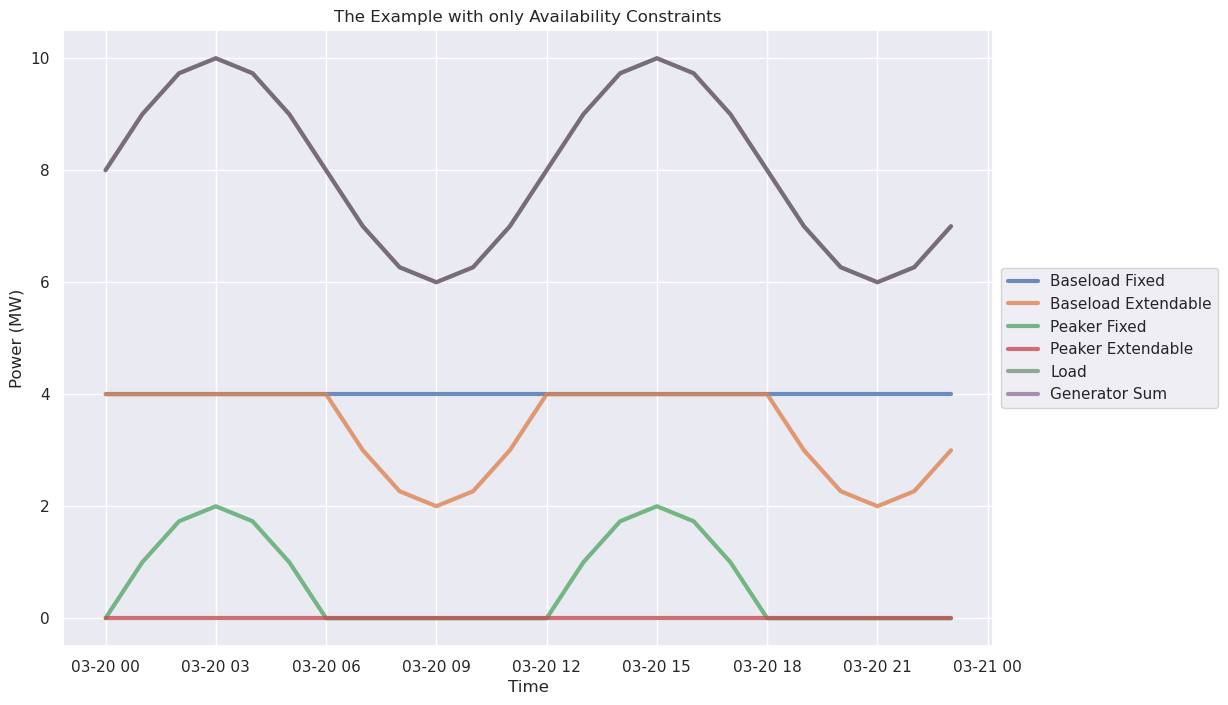

In [22]:
#This is what PyPSA has produced for the power time series for each generator in the network
gen = network.generators_t.p['Baseload Fixed'] + network.generators_t.p['Baseload Extendable'] + network.generators_t.p['Peaker Fixed'] + network.generators_t.p['Peaker Extendable']
plt.figure(figsize=(12, 8))
plt.plot(network.generators_t.p, linewidth=3, alpha=0.8)
plt.plot(load_series, linewidth=3, color='#326432', alpha=0.5)
plt.plot(gen, linewidth=3, color='#643264', alpha=0.5)
#plt.plot(network.snapshots, load_series.values.reshape((24)) + rhs, linewidth=3, color='#643264', alpha=0.5)
plt.legend(['Baseload Fixed', 'Baseload Extendable', 'Peaker Fixed', 'Peaker Extendable', 'Load', 'Generator Sum'], loc='right', bbox_to_anchor=(1.25, 0.5))
plt.title('The Example with only Availability Constraints')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.show()

In [23]:
#Despite Peaker Extendable never actively generating power, the solution still invests some capital into it
model.variables['Generator-p_nom'].solution

<xarray.DataArray 'solution' (Generator-ext: 2)>
array([4.       , 0.8660254])
Coordinates:
  * Generator-ext  (Generator-ext) object 'Baseload Extendable' 'Peaker Exten...

In [24]:
#How much money did each generator cost in the optimal solution?
bl_cost = round(network.generators_t.p['Baseload Fixed'].sum() * network.generators.loc['Baseload Fixed']['marginal_cost'], 2)
bl_cost_2 = round(network.generators_t.p['Baseload Extendable'].sum() * network.generators.loc['Baseload Extendable']['marginal_cost'], 2) + round(model.variables['Generator-p_nom'].solution.values[0] * network.generators.loc['Baseload Extendable']['capital_cost'], 2)
p_cost = round(network.generators_t.p['Peaker Fixed'].sum() * network.generators.loc['Peaker Fixed']['marginal_cost'], 2)
p_cost_2 = round(network.generators_t.p['Peaker Extendable'].sum() * network.generators.loc['Peaker Extendable']['marginal_cost'], 2) + round(model.variables['Generator-p_nom'].solution.values[1] * network.generators.loc['Peaker Extendable']['capital_cost'], 2)

print('Baseload Fixed: $' + str(bl_cost))
print('Baseload Extendable: $' + str(bl_cost_2))
print('Peaker Fixed: $' + str(p_cost))
print('Peaker Extendable: $' + str(p_cost_2))

#The total cost is the same as the solution found in the solver, which is labelled as the 'optimal objective'
print('The total cost was $' + str(round(bl_cost + bl_cost_2 + p_cost + p_cost_2, 2)))

Baseload Fixed: $576.0
Baseload Extendable: $726.4300000000001
Peaker Fixed: $149.28
Peaker Extendable: $4.33
The total cost was $1456.04


# A Lot of Constraints to View
Here is a function to print all of the constraints into a .txt file

In [25]:
#Takes a constraint from models.constraints['CONSTRAINT'] and prints it to a txt file
def constraint_text(constraint):
    with open('constraint.txt', 'w') as f:
        f.write('Constraint: ' + constraint.name + '\n')
        search = '^Constraint `' + constraint.name + '`' + '.*\n.*\n' #For removal when printing to the .txt file
        with redirect_stdout(f):
            for s in constraint.coords['snapshot'].values:
                string = str(constraint.sel({'snapshot': s}))
                remove = re.findall(search, string)
                print(string.replace(remove[0], ''))
        
        f.close()
        

### Adding a Ramping Reserve
Define an availability variable:

$avail_{i, t}^{ramp} := min(G_i - g_{i, t}, ramp_i^{up})$

$ramp_i^{up} := G_i \cdot \text{fraction of availability}$

In terms of *linopy* constraints:

$0 \leq avail_{i, t}^{ramp} \leq ramp_i^{up}$

$0 \leq avail_{i, t}^{ramp} \leq G_i - g_{i, t}$

This example will attempt to introduce a simple ramping constraint of a constant 0.2 for the generators.

In [26]:
#Ramping (Gi * fraction of availability)
#Constraints are called 'Fixed Ramping' and '<EXTENDABLE GENERATOR NAME> Ramping'
def ramping_ramp(model, network, fractions_extendable, fractions_fixed):
    #Get variables for the extendable type of generators
    extendable = network.generators.loc[network.generators['p_nom_extendable'] == True].index

    #Create availability variables for the generator types
    avail_extendable = model.add_variables(lower=0, coords=model.variables['Generator-p'].sel({'snapshot': network.snapshots, 'Generator': network.generators.loc[network.generators['p_nom_extendable'] == True].index}).coords, name='Extended Availability')
    avail_fixed = model.add_variables(lower=0, coords=model.variables['Generator-p'].sel({'snapshot': network.snapshots, 'Generator': network.generators.loc[network.generators['p_nom_extendable'] == False].index}).coords, name='Fixed Availability')

    #Fixed ramping constraint is pretty simple, take a fraction of their fixed p_nom values
    model.add_constraints(avail_fixed <= fractions_fixed * network.generators.loc[network.generators['p_nom_extendable'] == False]['p_nom'].values * np.ones((len(network.snapshots), len(fractions_fixed))), name='Fixed Ramping')

    #Extendable ramping is more complex, I ended up having to make each extendable generator have its own constraint
    constraint_extendable = avail_extendable <= fractions_extendable * model.variables['Generator-p_nom']

    for gen in extendable:
        #Selecting constraints in constraint_extendable such that there is only one generator
        model.add_constraints(constraint_extendable.sel({'snapshot': network.snapshots, 'Generator': gen, 'Generator-ext': gen}), name=gen + ' Ramping')

In [27]:
#Add ramping for each generator (Gi * fraction of availability)
ramping_ramp(model, network, [0.2, 0.2], [0.2, 0.2])

In [28]:
#Run this after ramping() above
#Ramping (Gi - g_t,i)
#Constraints are called 'Fixed Ramping, p_nom' and '<EXTENDABLE GENERATOR NAME> Ramping, p_nom'
def ramping_gen(model, network):
    #Get variables for the extendable type of generators
    extendable = network.generators.loc[network.generators['p_nom_extendable'] == True].index
    avail_extendable = model.variables['Extended Availability']
    avail_fixed = model.variables['Fixed Availability']

    #Add constraint for generators with a fixed p_nom
    fixed_Gi = network.generators.loc[network.generators['p_nom_extendable'] == False]['p_nom'].values * np.ones((len(network.snapshots), len(network.generators.loc[network.generators['p_nom_extendable'] == False]['p_nom'])))
    model.add_constraints(avail_fixed + model.variables['Generator-p'].sel({'snapshot': network.snapshots, 'Generator': network.generators.loc[network.generators['p_nom_extendable'] == False].index}) <= fixed_Gi, name='Fixed Ramping, p_nom')

    #Extendable ramping is more complex, I ended up having to make each extendable generator have its own constraint
    constraint_extendable = avail_extendable <= model.variables['Generator-p_nom'] - model.variables['Generator-p'].sel({'snapshot': network.snapshots, 'Generator': network.generators.loc[network.generators['p_nom_extendable'] == True].index})
    for gen in extendable:
        #Selecting constraints in constraint_extendable such that there is only one generator
        model.add_constraints(constraint_extendable.sel({'snapshot': network.snapshots, 'Generator': gen, 'Generator-ext': gen}), name=gen + ' Ramping, p_nom')

In [29]:
#Add ramping for each generator (Gi - g_t,i)
ramping_gen(model, network)

In [30]:
#Checking our newly added constraints, there should be 6 labelled 'Ramping' in this example
model.constraints

linopy.model.Constraints
------------------------
 * Generator-ext-p_nom-lower (Generator-ext)
 * Generator-ext-p_nom-upper (Generator-ext)
 * Generator-fix-p-lower (snapshot, Generator-fix)
 * Generator-fix-p-upper (snapshot, Generator-fix)
 * Generator-ext-p-lower (snapshot, Generator-ext)
 * Generator-ext-p-upper (snapshot, Generator-ext)
 * Bus-nodal_balance (Bus, snapshot)
 * Reserve-power (snapshot)
 * Fixed Ramping (snapshot, Generator)
 * Baseload Extendable Ramping (snapshot, Generator, Generator-ext)
 * Peaker Extendable Ramping (snapshot, Generator, Generator-ext)
 * Fixed Ramping, p_nom (snapshot, Generator)
 * Baseload Extendable Ramping, p_nom (snapshot, Generator, Generator-ext)
 * Peaker Extendable Ramping, p_nom (snapshot, Generator, Generator-ext)

In [31]:
#Trying out the constraint to .txt file function on the newly added 'Fixed Ramping, p_nom' constraint
constraint_text(model.constraints['Fixed Ramping, p_nom'])

### Adding the System Ramping Constraint
This is just the sum of all of the available ramping greater than or equal to the available ramping for the system times the load series.

The final constraint we are hoping to achieve from this:

$\sum_{i \in Generators} avail_{i, t}^{ramp} \geq avail_{system, t}^{ramp} \cdot L_t, \forall t \in T$

This example will attempt to introduce a simple ramping constraint of a constant 0.3 for the system.

In [32]:
#Availability for the entire system, defined above
system = model.variables['Extended Availability'].sum('Generator') + model.variables['Fixed Availability'].sum('Generator') >= 0.3 * np.array(load_data)
system

Constraint (unassigned) (snapshot: 24):
---------------------------------------
[2019-03-20T00:00:00.000000000]: +1 Extended Availability[2019-03-20 00:00:00, Baseload Extendable] + 1 Extended Availability[2019-03-20 00:00:00, Peaker Extendable] + 1 Fixed Availability[2019-03-20 00:00:00, Baseload Fixed] + 1 Fixed Availability[2019-03-20 00:00:00, Peaker Fixed] ≥ 2.4
[2019-03-20T01:00:00.000000000]: +1 Extended Availability[2019-03-20 01:00:00, Baseload Extendable] + 1 Extended Availability[2019-03-20 01:00:00, Peaker Extendable] + 1 Fixed Availability[2019-03-20 01:00:00, Baseload Fixed] + 1 Fixed Availability[2019-03-20 01:00:00, Peaker Fixed] ≥ 2.6999999999999997
[2019-03-20T02:00:00.000000000]: +1 Extended Availability[2019-03-20 02:00:00, Baseload Extendable] + 1 Extended Availability[2019-03-20 02:00:00, Peaker Extendable] + 1 Fixed Availability[2019-03-20 02:00:00, Baseload Fixed] + 1 Fixed Availability[2019-03-20 02:00:00, Peaker Fixed] ≥ 2.919615242270663
[2019-03-20T03:00:00.

In [33]:
#Adding the system availability constraint and checking that it has been added.
model.add_constraints(system, name='System Availability')
model.constraints

linopy.model.Constraints
------------------------
 * Generator-ext-p_nom-lower (Generator-ext)
 * Generator-ext-p_nom-upper (Generator-ext)
 * Generator-fix-p-lower (snapshot, Generator-fix)
 * Generator-fix-p-upper (snapshot, Generator-fix)
 * Generator-ext-p-lower (snapshot, Generator-ext)
 * Generator-ext-p-upper (snapshot, Generator-ext)
 * Bus-nodal_balance (Bus, snapshot)
 * Reserve-power (snapshot)
 * Fixed Ramping (snapshot, Generator)
 * Baseload Extendable Ramping (snapshot, Generator, Generator-ext)
 * Peaker Extendable Ramping (snapshot, Generator, Generator-ext)
 * Fixed Ramping, p_nom (snapshot, Generator)
 * Baseload Extendable Ramping, p_nom (snapshot, Generator, Generator-ext)
 * Peaker Extendable Ramping, p_nom (snapshot, Generator, Generator-ext)
 * System Availability (snapshot)

In [34]:
#Run the solver again
network.optimize.solve_model(solver_name='cbc')

INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.io: Writing time: 0.06s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 194 primals, 459 duals
Objective: 1.49e+03
Solver model: not available
Solver message: Optimal - objective value 1491.12665680


/home/ayaka/miniconda3/lib/python3.10/site-packages/linopy/common.py:120: UserWarning: Coordinates across variables not equal. Perform outer join.
  warn("Coordinates across variables not equal. Perform outer join.", UserWarning)
/home/ayaka/miniconda3/lib/python3.10/site-packages/linopy/common.py:120: UserWarning: Coordinates across variables not equal. Perform outer join.
  warn("Coordinates across variables not equal. Perform outer join.", UserWarning)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Reserve-power, Fixed Ramping, Baseload Extendable Ramping, Pea

Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Apr 19 2023 

command line - cbc -printingOptions all -import /tmp/linopy-problem-6ete9fdb.lp -solve -solu /tmp/linopy-solve-c1lajcil.sol (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 241 (-218) rows, 194 (0) columns and 626 (-332) elements
Perturbing problem by 0.001% of 60 - largest nonzero change 0.000644292 ( 0.0036560461%) - largest zero change 0.00015926882
0  Obj 0 Primal inf 265.6899 (49)
79  Obj 1475.5432 Primal inf 33.04847 (31)
116  Obj 1491.1614
Optimal - objective value 1491.1267
After Postsolve, objective 1491.1267, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 1491.126657 - 116 iterations time 0.012, Presolve 0.00
Total time (CPU seconds):       0.06   (Wallclock seconds):       0.00



('ok', 'optimal')

### Looking at the Solution Once More
This plot will illustrate how the ramping constraints we added affected the plot. In this case, it caused _Baseload Fixed_ to not run at its full rated nominal power for the entire load, unlike the previous two plots. Also not visible on this plot but further below, _Peaker Extendable_ was heavily invested into, **with the solution investing in 7.5MW into it**.

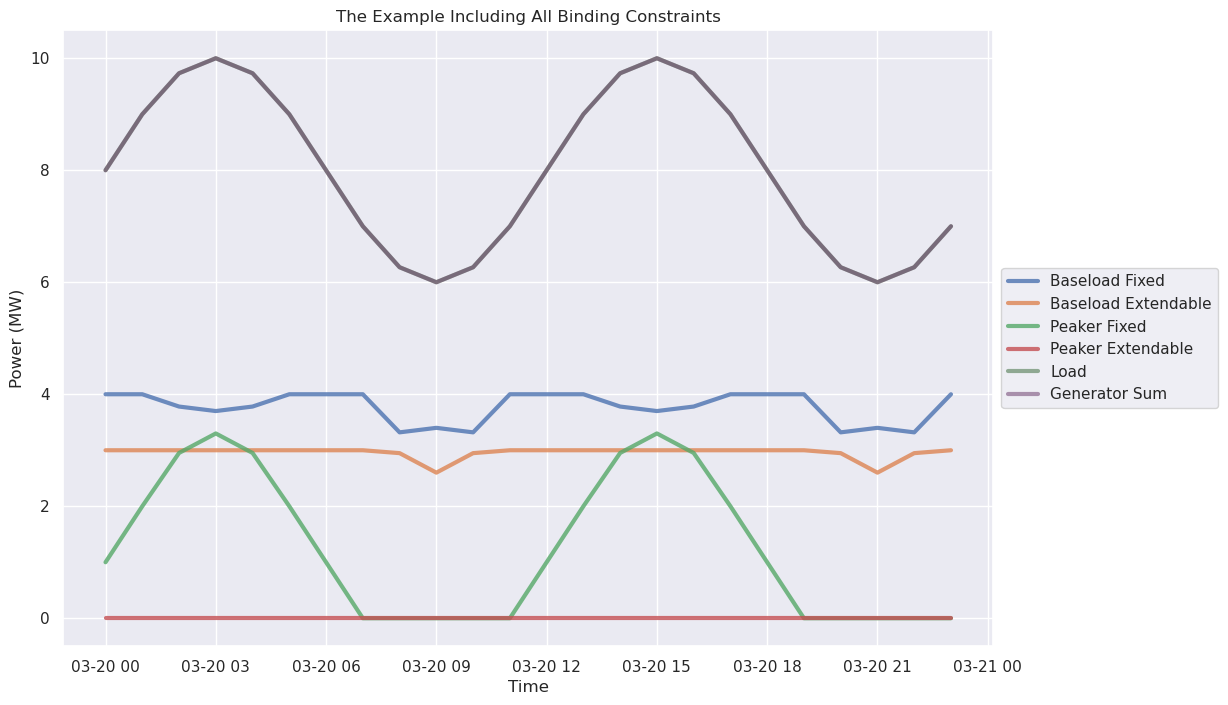

In [35]:
#This is what PyPSA has produced for the power time series for each generator in the network
gen = network.generators_t.p['Baseload Fixed'] + network.generators_t.p['Baseload Extendable'] + network.generators_t.p['Peaker Fixed'] + network.generators_t.p['Peaker Extendable']
plt.figure(figsize=(12, 8))
plt.plot(network.generators_t.p, linewidth=3, alpha=0.8)
plt.plot(load_series, linewidth=3, color='#326432', alpha=0.5)
plt.plot(network.snapshots, gen, linewidth=3, color='#643264', alpha=0.5)
plt.legend(['Baseload Fixed', 'Baseload Extendable', 'Peaker Fixed', 'Peaker Extendable', 'Load', 'Generator Sum'], loc='right', bbox_to_anchor=(1.25, 0.5))
plt.title('The Example Including All Binding Constraints')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.show()

In [36]:
#How much money did each generator cost in the optimal solution?
bl_cost = round(network.generators_t.p['Baseload Fixed'].sum() * network.generators.loc['Baseload Fixed']['marginal_cost'], 2)
bl_cost_2 = round(network.generators_t.p['Baseload Extendable'].sum() * network.generators.loc['Baseload Extendable']['marginal_cost'], 2) + round(model.variables['Generator-p_nom'].solution.values[0] * network.generators.loc['Baseload Extendable']['capital_cost'], 2)
p_cost = round(network.generators_t.p['Peaker Fixed'].sum() * network.generators.loc['Peaker Fixed']['marginal_cost'], 2)
p_cost_2 = round(network.generators_t.p['Peaker Extendable'].sum() * network.generators.loc['Peaker Extendable']['marginal_cost'], 2) + round(model.variables['Generator-p_nom'].solution.values[1] * network.generators.loc['Peaker Extendable']['capital_cost'], 2)

print('Baseload Fixed: $' + str(bl_cost))
print('Baseload Extendable: $' + str(bl_cost_2))
print('Peaker Fixed: $' + str(p_cost))
print('Peaker Extendable: $' + str(p_cost_2))

#The total cost is the same as the solution found in the solver, which is labelled as the 'optimal objective'
print('The total cost was $' + str(round(bl_cost + bl_cost_2 + p_cost + p_cost_2, 2)))

Baseload Fixed: $543.6
Baseload Extendable: $605.96
Peaker Fixed: $304.07
Peaker Extendable: $37.5
The total cost was $1491.13


In [37]:
#With these ramping constraints added, the solution invests quite a bit of capital into Peaker Extended, yet it is still never actively generating power for the load
model.variables['Generator-p_nom'].solution

<xarray.DataArray 'solution' (Generator-ext: 2)>
array([3. , 7.5])
Coordinates:
  * Generator-ext  (Generator-ext) object 'Baseload Extendable' 'Peaker Exten...